## <font color='blue'>SME0104 - Cálculo Numérico</font>

### Primeiro Trabalho em Grupo 
#### Comparação de Métodos na Solução do Laplaciano em Grafos para propagação de informação

**Luis Gustavo Nonato**

------

Considere os arquivos `manh.el` e `manh.xy` que fornecem as arestas e as coordenadas dos vértices do grafo de ruas da ilha de Manhattan, NY (arquivos disponíveis para download no Google Drive).

O grafo de ruas possui diversas componentes conexas, considerando somente a maior componente conexa, você deve realizar as seguintes tarefas:
1. Selecione alguns vértices do grafo $v_{i_1},v_{i_2},\ldots,v_{i_k},\, k<<n$ ($n$ é o número de vértices na maior componente do grafo e $k$ é um número bem menor que $n$, $k=10$ por exemplo) e atribua valores distindos $c_{i_1},c_{i_2},\ldots,c_{i_k}$ a cada um dos vértices selecionados (por exemplo valores no intervalo (0,10]);
2. Construa a matriz Laplaciana $L$ do grafo de ruas;
3. Construa a matriz de penalidades $P$, sendo $P$ é uma matriz diagonal onde a entrada $P_{jj}=\alpha$ se $j$ corresponde ao índice de algum dos vértices escolhidos no item 1 acima ($\alpha=1.0e7$ por exemplo), sendo $P_{ii}=0$ caso contrário.
4. Construa um vetor $b$ da seguinte forma:
$$
b_{j} = \left\{\begin{matrix} c_{i_s} & \text{ se } j = i_s \\ 0 & \text{ caso contrário}\end{matrix}\right.
$$
5. Compare o tempo de solução do sistema
$$
(L+P)x = Px
$$
para os métodos:
    - Decomposição LU
    - Cholesky
    - Jacobi e Gaus-Seidel
    - Gradientes Conjugados
    
6. Refaça as tarefas com representação por matriz esparsa e matrizes cheias, comparando os resultados.

In [1]:
# Solucao
import numpy as np
import networkx as nx
import scipy.linalg 
import scipy.sparse.linalg 
from copy import deepcopy
import matplotlib.pyplot as plt
import time

def gauss_seidel(A, b, tolerance, max_iterations, x):
    #x is the initial condition
    iter1 = 0
    #Iterate
    for k in range(max_iterations):
        iter1 = iter1 + 1
        x_old  = x.copy()
        
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
            
        #Stop condition 
        #LnormInf corresponds to the absolute value of the greatest element of the vector.
        
        LnormInf = max(abs((x - x_old)))/max(abs(x_old))   
        if  LnormInf < tolerance:
            break
    
           
    return x


def jacobi(A,b):
    linha, coluna = np.shape(A)
    s = np.zeros((linha,coluna))
    g = np.zeros(linha)

    for i in range (0,linha):
        s[i,:] = A[i,:]/A[i,i]
        g[i] = b[i]/A[i,i]
        s[i,i] = 0

        s = -s

        numero_iteracao = 10**4
        x = np.zeros(coluna)
        for i in range(numero_iteracao):
            x = np.dot(s,x)+g 

        return x

In [2]:
G = nx.read_edgelist("./dados/manh.el", create_using=nx.Graph, nodetype=int)

qnt = np.arange(G.number_of_nodes()+1)
mapping = dict(zip(G, qnt))

G = nx.relabel_nodes(G, mapping)

componentes = [G.subgraph(c).copy() for c in nx.connected_components(G)]
# nx.draw_networkx(componentes[0],node_size=10,with_labels=False)

number_of_nodes = []
for i in range(len(componentes)):
  number_of_nodes.append(componentes[i].number_of_nodes())

index_maior_componente = number_of_nodes.index(max(number_of_nodes))
grafo_maior_componente = componentes[index_maior_componente]

matriz_laplaciana = nx.laplacian_matrix(grafo_maior_componente).todense()
matriz_penalidade = np.zeros( (len(matriz_laplaciana), len(matriz_laplaciana)))

penalidade = 10**4
for i in range(11):
  matriz_penalidade[i][i] = penalidade

b = np.zeros((len(matriz_penalidade),1))

b[0][0] = 250000
b[1][0] = 40000
b[2][0] = 10000
b[3][0] = 270000
b[4][0] = 380000
b[5][0] = 390000
b[6][0] = 70000
b[7][0] = 400000
b[8][0] = 130000
b[9][0] = 280000
b[10][0] = 200000

A = np.add(matriz_laplaciana,matriz_penalidade)



In [3]:
# lu
start_lu = time.time()
lu, piv = scipy.linalg.lu_factor(A)
x_lu = scipy.linalg.lu_solve((lu,piv),b)
end_lu = time.time()

# # chow chow
start_cho = time.time()
c, low = scipy.linalg.cho_factor(A)
x_cho = scipy.linalg.cho_solve((c,low),b)
end_cho = time.time()

# # jacobi
start_jaco = time.time()
x0 = np.ones((len(matriz_penalidade),1))
x_jaco = jacobi(A,b)
end_jaco = time.time()

# # gauss_seidel
start_seidel = time.time()
x0 = np.ones((len(matriz_penalidade),1))
x_seidel = gauss_seidel(A,b,10**-4,100,x0)
end_seidel = time.time()

# # cg
start_cg = time.time()
a_sparse = scipy.sparse.csc_matrix(A)
x_cg_aux = scipy.sparse.linalg.cg(a_sparse,b)
x_cg = x_cg_aux[0]
end_cg = time.time()


print("\nLU:")
print(x_lu)
print(end_lu - start_lu)
print("\nCho:")
print(x_cho)
print(end_cho - start_cho)
print("\nJaco:")
print(x_jaco)
print(end_jaco - start_jaco)
print("\nSeidel:")
print(x_seidel)
print(end_seidel - start_seidel)
print("\nCG:")
print(x_cg)
print(end_cg - start_cg)


LU:
[[24.99570176]
 [ 4.00219997]
 [ 1.00320621]
 ...
 [19.69128397]
 [21.15301139]
 [27.4340616 ]]
6.178176403045654

Cho:
[[24.99570176]
 [ 4.00219997]
 [ 1.00320621]
 ...
 [19.69128397]
 [21.15301139]
 [27.4340616 ]]
4.224570989608765

Jaco:
[24.99250225  0.          0.         ...  0.          0.
  0.        ]
712.7775311470032

Seidel:
[[24.99570158]
 [ 4.0017315 ]
 [ 1.00278846]
 ...
 [ 2.6524559 ]
 [ 1.09889975]
 [ 1.00099351]]
35.529393911361694

CG:
[2.49956955e+01 4.00173681e+00 1.00280450e+00 ... 7.74799544e-01
 9.28538059e-19 0.00000000e+00]
0.7492315769195557


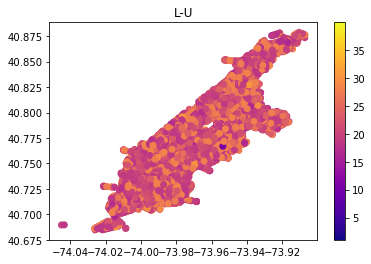

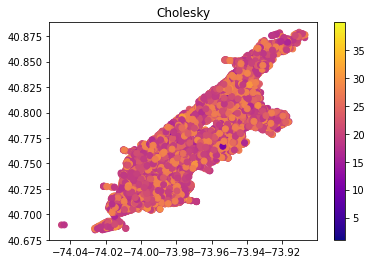

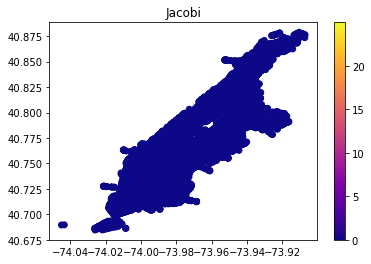

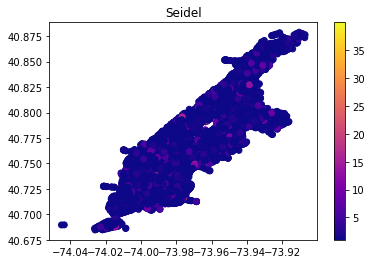

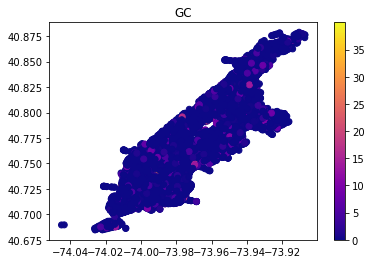

In [4]:
v = []
xy = []

for i in list(grafo_maior_componente.nodes):
  v.append(i)

f = open('./dados/manh.xy','r')
for row in f:
    row = row.split('\t')
    row[1] = row[1].split('\n')
    aux = row[1]

    xy.append([float(row[0]), float(aux[0])])

vertices_x = []
vertices_y = []
vertices = []

for i in v:
    vertices.append(xy[i])
    vertices_x.append(xy[i][0])
    vertices_y.append(xy[i][1])

plt.scatter(vertices_x, vertices_y, c=x_lu, cmap='plasma')
plt.title("L-U")
plt.colorbar()
plt.show()

plt.scatter(vertices_x, vertices_y, c=x_cho, cmap='plasma')
plt.title("Cholesky")
plt.colorbar()
plt.show()

plt.scatter(vertices_x, vertices_y, c=x_jaco, cmap='plasma')
plt.title("Jacobi")
plt.colorbar()
plt.show()

plt.scatter(vertices_x, vertices_y, c=x_seidel, cmap='plasma')
plt.title("Seidel")
plt.colorbar()
plt.show()

plt.scatter(vertices_x, vertices_y, c=x_cg, cmap='plasma')
plt.title("GC")
plt.colorbar()
plt.show()